# 1. Introduction

## 1.1 Background Information

Singapore is centrally located in South East Asia, serving as a hub for major airlines connecting tourists to dream destinations such as Thailand, Malaysia, Indonesia, etc. As a results, many will stop over for a few days to discover the country who is known as a culinary and shopping haven.

After having our daughter, my husband and I have not stopped travelling but our needs for accomodations have changed. For instance, we would need a kitchen to prepare home-cooked food for our baby so Airbnb has become one of our top options for finding an accomodation. Hence, this project is to help travellers with kids to identify appropriate accomodations to fully enjoy their stay in Singapore.

## 1.2 Problem Statement

There are 4000+ over accomodations in the Airbnb lisiting as of December 2020. How can we classify these accomodations into clusters and find more easily the right accomodation that corresponds to the budget and preferences of the travellers? This project will try to answer this question.

## 1.3 Target Audience

This report is dedicated to travellers who are looking for a short period of stay in Singapore. The results should give them a quick overview of which areas to stay that would satisfy their budget and preferences. The type of accomodations has been limited to "Entire place" as these is the accomodation most suitable for family but it can be also be relevant for travellers who seek for such type of accomodation.


# 2. Data
## 2.1 Data Require

- Listing of Singapore AirBnb accomodation
- Number of venues including restaurants, shopping malls and tourists attractions in the vicinity of the accomodation's neighborhood

## 2.2 Data Sources

Below is the link to the dataset.

- Airbnb accommodation lisiting from Inside Airbnb: http://insideairbnb.com/get-the-data.html (Data compiled on December 2020)

- Foursquare API to extract data on venues in a neighbourhood: https://developer.foursquare.com/

## 2.3 Data Understanding and preparation

In [83]:
# import libraries
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
!pip install folium
import folium

print('Libraires imported')

Libraires imported


In [84]:
#Fetch Singapore listing from AirBnB
df = pd.read_csv('http://data.insideairbnb.com/singapore/sg/singapore/2020-12-29/visualisations/listings.csv', low_memory = False)
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,266763,Francesca,North Region,Woodlands,1.44255,103.79580,Private room,79,180,1,2013-10-21,0.01,2,365
1,50646,Pleasant Room along Bukit Timah,227796,Sujatha,Central Region,Bukit Timah,1.33235,103.78521,Private room,80,90,18,2014-12-26,0.22,1,365
2,56334,COZICOMFORT,266763,Francesca,North Region,Woodlands,1.44246,103.79667,Private room,66,6,20,2015-10-01,0.17,2,365
3,71609,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,East Region,Tampines,1.34541,103.95712,Private room,174,90,20,2020-01-17,0.18,8,365
4,71896,B&B Room 1 near Airport & EXPO,367042,Belinda,East Region,Tampines,1.34567,103.95963,Private room,93,90,24,2019-10-13,0.21,8,365


In [85]:
df.shape

(4387, 16)

In order to simplify the table, we keep only the essential columns necessary for this project

In [86]:
# Keep only essential columns
df1 = df[["id", "neighbourhood", "latitude", "longitude", "room_type", "price", "minimum_nights", "availability_365", "reviews_per_month", "number_of_reviews"]]
df1.head()

,id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,availability_365,reviews_per_month,number_of_reviews
0,49091,Woodlands,1.44255,103.79580,Private room,79,180,365,0.01,1
1,50646,Bukit Timah,1.33235,103.78521,Private room,80,90,365,0.22,18
2,56334,Woodlands,1.44246,103.79667,Private room,66,6,365,0.17,20
3,71609,Tampines,1.34541,103.95712,Private room,174,90,365,0.18,20
4,71896,Tampines,1.34567,103.95963,Private room,93,90,365,0.21,24


We want to keep accomodations with the active hosts and hosts who accepts short term stays (ex: <7days) 

In [87]:
# Filter data to keep essential rows
df1 = df1[(df1.minimum_nights <= 7) # for short term stay
           & (df1.number_of_reviews >= 10) # active host
           & (~df1.room_type.isin(['Entire home/apt']) )
           & (df1.availability_365 >= 10)
          ]

df1 = df1.reset_index(drop = True)

df1.shape

(309, 10)

We check if all the rows are correctly filled and the types of data corresponds to the title of the column

In [88]:
df1.isnull().sum()

id                   0
neighbourhood        0
latitude             0
longitude            0
room_type            0
price                0
minimum_nights       0
availability_365     0
reviews_per_month    0
number_of_reviews    0
dtype: int64

In [89]:
df1.dtypes

id                     int64
neighbourhood         object
latitude             float64
longitude            float64
room_type             object
price                  int64
minimum_nights         int64
availability_365       int64
reviews_per_month    float64
number_of_reviews      int64
dtype: object

We plot box plot to see the distribution of the prices and if there is a need to remove outliers

Text(0.5, 0.98, '')

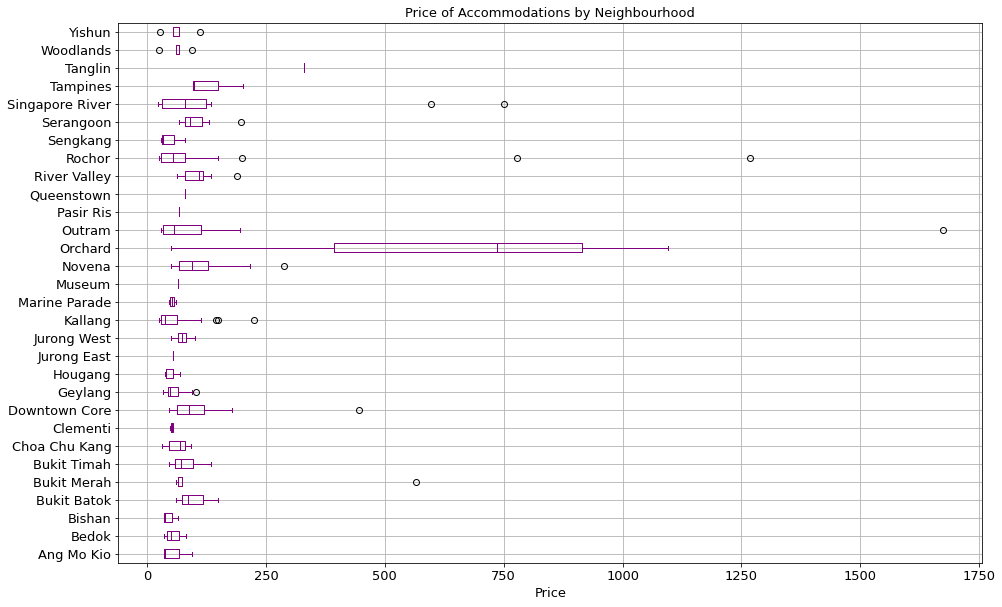

In [90]:
# Plot a box plot
box = df1[['neighbourhood','price']].boxplot(
    column='price', 
    by='neighbourhood',
    vert=False, 
    fontsize=13, 
    figsize=(15,10),
    color = 'purple'
)

box.get_figure().gca().set_title("Price of Accommodations by Neighbourhood", fontsize=13)
box.get_figure().gca().set_xlabel('Price', fontsize=13)
box.get_figure().suptitle('')

Since there are outliers, we will to remove them to make the clustering more efficient 

In [91]:
# Calculate Q1, Q3 and IQR
Q1 = df1.price.quantile(0.25)
Q3 = df1.price.quantile(0.75)
IQR = Q3 - Q1

# Remove data that is not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR)
condition = (df1.price >= Q1 - 1.5 * IQR) & (df1.price <= Q3 + 1.5 *IQR)
df1 = df1.loc[condition]  

df1.shape

(291, 10)

Text(0.5, 0.98, '')

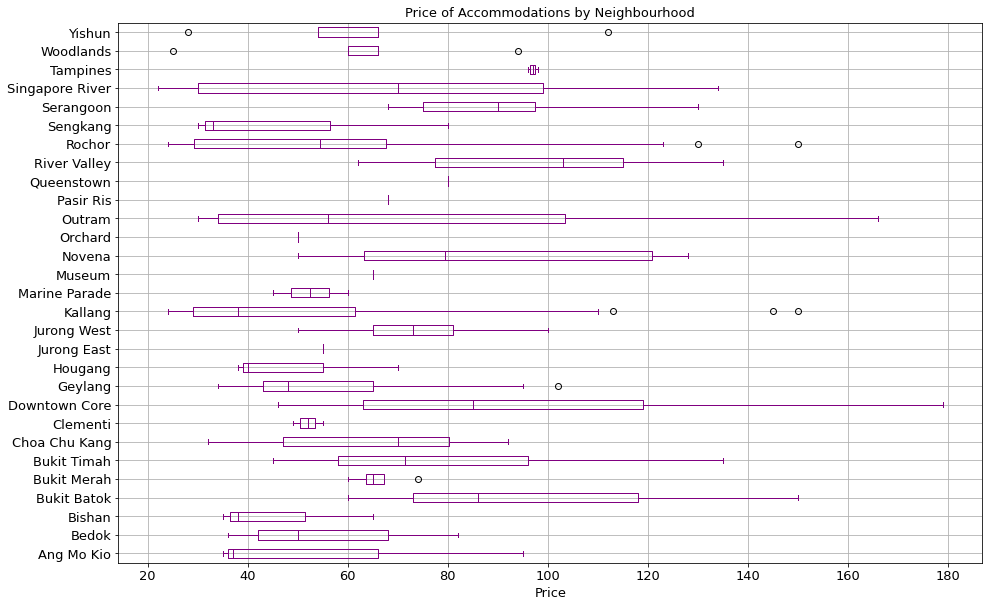

In [92]:
# Plot a box plot
box = df1[['neighbourhood','price']].boxplot(
    column='price', 
    by='neighbourhood',
    vert=False, 
    fontsize=13, 
    figsize=(15,10),
    color = 'purple'
)

box.get_figure().gca().set_title("Price of Accommodations by Neighbourhood", fontsize=13)
box.get_figure().gca().set_xlabel('Price', fontsize=13)
box.get_figure().suptitle('')

The distribution of the prices of the Airbnb's accomodation by neighbourhood is now ready for use in the further analysis

# 3. Methodology

Part 1: Exploratory Data Analysison Accomodation listing
- plot average price per neighbourhood
- plot accomodations on folium to see their distribution on Singapore's map

Part 2: Get Venues around accomodation
- use the foursquare API to find the venues around the accomadations
- explore the dataframe of the venues collected
- classify the venues them into main categories (Food, Shopping, Transport, etc.) that are of interest to travellers

Part 3: One Hot Encoding and K-means Clustering

Part 4: Further analysis on each cluster¶

## 3.1 Exploratory Data Analysison Accomodation listing

In [93]:
# dataframe with mean of average in each neighbourhood
df2 = df1.groupby("neighbourhood", as_index = False).agg({"price":"mean"})
df2 = df2.sort_values("price").reset_index(drop = True)

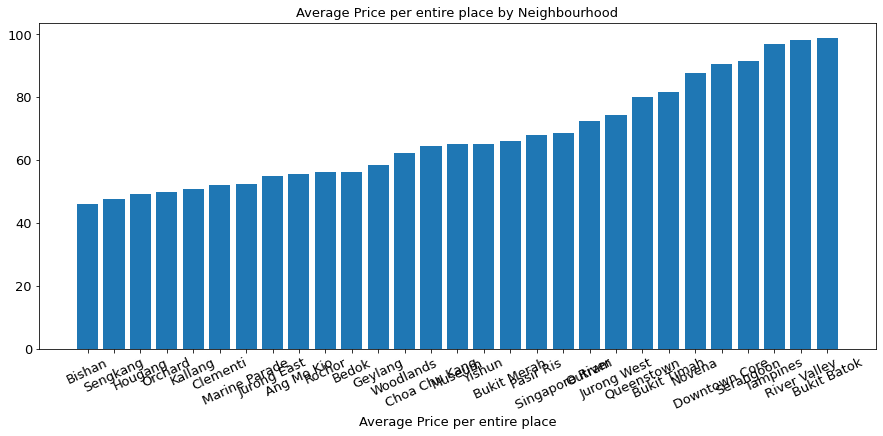

In [94]:
# plot a bar graph on Average Accomodation Price by Neighbourhood
fig, ax = plt.subplots(figsize=(15,6))
x = df2.neighbourhood
y = df2.price
ax.bar(x, y)
ax.set_xlabel('Average Price per entire place', fontsize = 13)
ax.set_title('Average Price per entire place by Neighbourhood', fontsize = 13)
plt.xticks(x, rotation=25)
plt.tick_params(labelsize=13)
plt.show()

In [95]:
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
address = 'Singapore'

geolocator = Nominatim(user_agent="sg_explorer")
location_sg = geolocator.geocode(address)
latitude_sg = location_sg.latitude
longitude_sg = location_sg.longitude
print('The geograpical coordinate of Singapore are {}, {}.'.format(latitude_sg, longitude_sg))

The geograpical coordinate of Singapore are 1.357107, 103.8194992.


In [96]:
# create map of New York using latitude and longitude values
map_singapore = folium.Map(location=[latitude_sg, longitude_sg], zoom_start=12)

# add markers to map
for lat, lng, neigh in zip(df1['latitude'], df1['longitude'],df1['neighbourhood']):
    label = '{}'.format(neigh)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_singapore)  

map_singapore

## 3.2: Get Venues around accomodation

Set credentials for Foursquare API

In [97]:
# @hidden cell
CLIENT_ID = '4YSXXC2VGJBWVQ3AH4LJC3WA423P3SFYNL03EZ5UPAKUAQRB' # your Foursquare ID
CLIENT_SECRET = 'FDGKCJRUSWZWZQODIKW0UDWYE1IU5PSTSBH2JNSZKPCIY4FC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50 # limit of number of venues returned by Foursquare API
radius = 400 

Define getNearbyVenues function which is used to call Foursquare API to gather the venues 

In [98]:
def getNearbyVenues(names, latitudes, longitudes, radius, limit):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['id', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [99]:
# call the function to get a dataframe of venues
df_v = getNearbyVenues(names=df1['id'],
                       latitudes=df1['latitude'],
                       longitudes=df1['longitude'],
                       radius = radius,
                       limit = LIMIT
                      )

KeyError: 'groups'

Quick expoloratory analysis on the venues dataframe using head, shape and groupby

In [24]:
df_v.head()

,id,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,56334,1.44246,103.79667,Asia Ghani,1.437431,103.795388,Malay Restaurant
1,56334,1.44246,103.79667,Kampung Admiralty Hawker Centre,1.439939,103.800774,Food Court
2,56334,1.44246,103.79667,Starbucks,1.439761,103.800659,Coffee Shop
3,56334,1.44246,103.79667,McDonald's,1.445931,103.798101,Fast Food Restaurant
4,56334,1.44246,103.79667,NTUC Fairprice,1.439955,103.800761,Supermarket


In [25]:
df_v.shape

(12641, 7)

In [26]:
df_v1=df_v.groupby("Venue Category").count()
df_v1

,id,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Accessories Store,7,7,7,7,7,7
African Restaurant,1,1,1,1,1,1
American Restaurant,14,14,14,14,14,14
Argentinian Restaurant,9,9,9,9,9,9
Art Gallery,46,46,46,46,46,46
...,...,...,...,...,...,...
Wine Shop,1,1,1,1,1,1
Wings Joint,14,14,14,14,14,14
Women's Store,2,2,2,2,2,2


Classify all the venue categories into 5 main categories (food, entertainment, shopping, outdoor, transport and culture) for more efficient clustering

In [34]:
food = ['Restaurant', 'Food', 'Caf', 'Coffee', 'Dessert', 'Bakery', 'Snack', 'Burger','Burrito', 
        'Steakhouse', 'Buffet', 'Sandwich', 'Bubble Tea', 'Ice Cream', 'Noodle','Breakfast','Cupcake']

entertainment = ['Aquarium', 'Park', 'Scenic Lookout','Karaoke', 'Pub', 'Wine', 'Bar','Spa', 'Gastropub', 'Liquor']

shopping = ['Shopping', 'Boutique', 'Clothing', 'Cosmetics', 'Jewelry','Store']

outdoor = ['Court', 'Trail', 'Bay', 'Field', 'Park', 'Beach', 'Waterfront', 'Stadium', 'Garden', 'Plaza', 'Campground','Farm']

transport = ['Station', 'Bus']

culture = ['Museum', 'Historic', 'Temple', 'Art','Concert','History','Club']

In [35]:
cat = food + entertainment + shopping + outdoor + transport + culture

In [36]:
# Get venues from custom categories
def getvenues(category):
    if any(word in category for word in cat):
        return True
    return False

In [37]:
# Define venues by our custom categories
def custom_cat(x):
    if any(word in x for word in food):
        return 'Food'
    if any(word in x for word in entertainment):
        return 'Entertainment'
    if any(word in x for word in shopping):
        return 'Shopping'
    if any(word in x for word in outdoor):        
        return 'Outdoor'
    if any(word in x for word in transport):            
        return 'Transport'
    if any(word in x for word in culture):            
        return 'Fine Art'

In [38]:
# Get top venues
def common_venues(row, n):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)      
    return row_categories_sorted.index.values[0:n] 

def common_venues_count(row, n):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False).astype(float)      
    return row_categories_sorted.values[0:n]

In [39]:
# Here, we exclude data that is not included in our custom categories
df_v2 = df_v[df_v['Venue Category'].apply(lambda x: getvenues(x))].reset_index(drop=True)

In [40]:
# Here, we add a new custom category column to our dataframe 
df_v2['custom_category']= df_v2['Venue Category'].apply(lambda x: custom_cat(x))

In [41]:
df_v2.head()

,id,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,custom_category
0,56334,1.44246,103.79667,Asia Ghani,1.437431,103.795388,Malay Restaurant,Food
1,56334,1.44246,103.79667,Kampung Admiralty Hawker Centre,1.439939,103.800774,Food Court,Food
2,56334,1.44246,103.79667,Starbucks,1.439761,103.800659,Coffee Shop,Food
3,56334,1.44246,103.79667,McDonald's,1.445931,103.798101,Fast Food Restaurant,Food
4,56334,1.44246,103.79667,KFC,1.437409,103.795428,Fast Food Restaurant,Food


## 3.3 One Hot Encoding and K-means Clustering

In [42]:
# one hot encoding
df_onehot = pd.get_dummies(df_v2[['custom_category']], prefix="", prefix_sep="")

In [43]:
# Add id column back to our dataframe
df_onehot['id'] = df_v['id']

In [44]:
df_group = (np.round(df_onehot.groupby('id').mean(),2)).reset_index()

In [45]:
# get top 3 venues
n = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['id']
for ind in np.arange(n):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
for ind in np.arange(n):
    try:
        columns.append('{}{} Most Common Venue Share'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue Share'.format(ind+1))        
        

# create a new dataframe
df_group2 = pd.DataFrame(columns=columns)
df_group2['id'] = df_group['id']

for ind in np.arange(df_group.shape[0]):
    stats = np.around(common_venues_count(df_group.iloc[ind, :], n),2) 
    category = common_venues(df_group.iloc[ind, :], n)
    df_group2.iloc[ind, 1:] = np.concatenate([category, stats])

We use the k-means to create clusters

In [46]:
# set number of clusters
k = 3

df_cluster = df_group.drop('id', axis = 1)

# k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(df_cluster)

# add cluster label
df_group2.insert(0, 'Cluster Labels', kmeans.labels_)

We join the table with cluster label with the main accomodation table to have all the details in one table

In [47]:
df_merged = df1.copy()
df_merged  = df_merged.join(df_group2.set_index('id'), on='id')
df_merged = df_merged.dropna()
df_merged['Cluster Labels'] = df_merged['Cluster Labels'].astype('int')

Now we display the cluster on a map

In [48]:
map_cluster = folium.Map(location=[latitude_sg, longitude_sg], zoom_start=12)
# set color for the clusters
x = np.arange(k)
ys = [x + i + (i*x)**2 for i in range(k)] 
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neigh, cluster in zip(df_merged['latitude'], df_merged['longitude'], df_merged['neighbourhood'], df_merged['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_cluster)
       
map_cluster

In [50]:
clus0 = df_merged.loc[df_merged['Cluster Labels'] == 0]
clus0.describe()

,id,latitude,longitude,price,minimum_nights,availability_365,reviews_per_month,number_of_reviews,Cluster Labels
count,7.500000e+01,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.0
mean,1.637272e+07,1.314111,103.844743,66.066667,1.906667,275.946667,1.009067,46.720000,0.0
std,7.644472e+06,0.031761,0.044832,38.827871,1.357395,120.743966,0.990212,49.707131,0.0
min,5.633400e+04,1.275230,103.690270,24.000000,1.000000,12.000000,0.170000,10.000000,0.0
25%,1.046912e+07,1.296110,103.843850,33.000000,1.000000,164.000000,0.385000,15.000000,0.0
50%,1.651938e+07,1.311140,103.849680,55.000000,1.000000,356.000000,0.560000,26.000000,0.0
75%,2.210665e+07,1.318280,103.859620,87.500000,2.000000,364.000000,1.210000,54.500000,0.0
max,3.252621e+07,1.442460,103.948520,179.000000,6.000000,365.000000,4.370000,247.000000,0.0


In [51]:
clus0['1st Most Common Venue'].value_counts()

Food    75
Name: 1st Most Common Venue, dtype: int64

In [52]:
clus0['2nd Most Common Venue'].value_counts()

Entertainment    34
Shopping         29
Transport         8
Outdoor           2
Fine Art          2
Name: 2nd Most Common Venue, dtype: int64

In [53]:
clus0['3rd Most Common Venue'].value_counts()

Shopping         23
Entertainment    18
Transport        13
Outdoor          12
Fine Art          9
Name: 3rd Most Common Venue, dtype: int64

In [54]:
clus1 = df_merged.loc[df_merged['Cluster Labels'] == 1]

In [55]:
clus1.describe()

,id,latitude,longitude,price,minimum_nights,availability_365,reviews_per_month,number_of_reviews,Cluster Labels
count,5.500000e+01,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.0
mean,1.643534e+07,1.320542,103.839067,64.163636,2.090909,279.690909,1.372545,62.127273,1.0
std,9.000140e+06,0.040066,0.051862,27.844651,1.590163,117.002987,1.304754,65.217600,0.0
min,9.188800e+05,1.275200,103.691300,24.000000,1.000000,10.000000,0.180000,10.000000,1.0
25%,8.800374e+06,1.287705,103.837195,36.000000,1.000000,177.500000,0.480000,20.000000,1.0
50%,1.776847e+07,1.311320,103.845750,65.000000,1.000000,351.000000,0.910000,39.000000,1.0
75%,2.353027e+07,1.336300,103.860030,84.500000,2.000000,365.000000,1.790000,76.000000,1.0
max,3.196573e+07,1.447280,103.960020,120.000000,7.000000,365.000000,5.660000,322.000000,1.0


In [56]:
clus1['1st Most Common Venue'].value_counts()

Food    55
Name: 1st Most Common Venue, dtype: int64

In [57]:
clus1['2nd Most Common Venue'].value_counts()

Entertainment    40
Shopping         13
Transport         1
Outdoor           1
Name: 2nd Most Common Venue, dtype: int64

In [62]:
clus1['3rd Most Common Venue'].value_counts()

Shopping         20
Outdoor          12
Entertainment    11
Fine Art          7
Transport         5
Name: 3rd Most Common Venue, dtype: int64

In [67]:
clus2 = df_merged.loc[df_merged['Cluster Labels'] == 2]
clus2.describe()

,id,latitude,longitude,price,minimum_nights,availability_365,reviews_per_month,number_of_reviews,Cluster Labels
count,9.600000e+01,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.0
mean,1.607287e+07,1.318627,103.844673,66.177083,2.041667,281.260417,1.296250,57.239583,2.0
std,7.844727e+06,0.034009,0.038111,36.946617,1.521195,102.239064,1.153604,50.493094,0.0
min,7.478130e+05,1.276630,103.695170,22.000000,1.000000,29.000000,0.170000,10.000000,2.0
25%,9.640960e+06,1.298872,103.843308,34.000000,1.000000,180.000000,0.457500,19.000000,2.0
50%,1.688838e+07,1.311630,103.850055,57.000000,1.000000,344.000000,0.885000,38.000000,2.0
75%,2.188774e+07,1.321015,103.860662,86.750000,2.000000,364.000000,1.705000,76.000000,2.0
max,3.398276e+07,1.452040,103.948140,165.000000,7.000000,365.000000,6.790000,262.000000,2.0


In [64]:
clus2['1st Most Common Venue'].value_counts()

Food    96
Name: 1st Most Common Venue, dtype: int64

In [65]:
clus2['2nd Most Common Venue'].value_counts()

Shopping         46
Entertainment    36
Transport         9
Outdoor           3
Fine Art          2
Name: 2nd Most Common Venue, dtype: int64

In [61]:
clus2['3rd Most Common Venue'].value_counts()

Shopping         33
Entertainment    27
Outdoor          22
Fine Art          8
Transport         6
Name: 3rd Most Common Venue, dtype: int64

# 4.0 Results and Discussion

Cluster 0 (red): 
- Average price $67
- Max price $104
Top Venues nearby: Food, Entertainment, SHopping

Cluster 1 (purple):
- Average price $64
- Max price $120
Top Venues nearby: Food, Entertainment, SHopping
    
 
 Cluster 2 (green):
- Average price $66
- Max price $165
Top Venues nearby: Food, Shopping, SHopping

The cluster are not so well separated as maybe the radius of venue explore is set too high for the scale of Singapore at 700 and I could not manage to re-run the codes with a smaller radius. However, we can see that the prices are similar whether it is downtown or further away from city centre, all ameninties are very close be it restaurant, transport, outdoor or culture. 
 

# 5. Conclusion

I set off to identify the best accomodations for families looking for short stay in Singapore.

Through compiling of data from Airbnb and venues from FourSquare, I used the K-means clustering to form 3 clusters. However, I found that the clusters are overlapping and this maybe due to small size of the city state. Nevertheless, with this result, we can see that the different neighbour offers similar amentities (restaurants and malls), outdoor activities and convenience of transport. Hence, we conclude base on this finding that any cluster is suitable for families

To further improve the analysis, we could try with a smaller radius in the parameters used in the Foursquare API to see with it, the clusters formed maybe more distinct.